# **ISB-CGC Query of the Month, November 2018**
- Kawther Abdilleh, David L Gibbs

For more Queries:  https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/QueryOfTheMonthClub.html

Part of the ISB-CGC:  http://www.isb-cgc.org 
 

### First we need to authenticate ourselves.  



In [0]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


### ** Let's begin by querying our newly transformed vcf table, containing variants for the human chromosome 21. **

For instructions on the BigQuery transformation see: https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/QueryOfTheMonthClub.html

In [0]:
%%bigquery --project MY-PROJECT-ID df
select 
  reference_name,
  start_position,
  end_position
from
  `isb-cgc.QotM.1000genomes`
limit 
  10

,reference_name,start_position,end_position
0,21,44061667,44105124
1,21,44061693,44104791
2,21,44075242,44076807
3,21,44063828,44063829
4,21,44081693,44081694
5,21,44076133,44076134
6,21,44095212,44095213
7,21,44059175,44059176
8,21,44097081,44097082
9,21,44080981,44080982


### **Colaboratory notebooks allow us to leverage the power of Python and use pandas to create & save queries to datatables. **

In [0]:
import pandas as pd

project_id = 'MY-PROJECT-ID'


In [0]:

df = pd.io.gbq.read_gbq('''
select 
  reference_name as chr,
  start_position,
  end_position
from
  `isb-cgc.QotM.1000genomes`
limit 
  10
''', project_id=project_id, verbose=False, dialect='standard')

df.head()

,chr,start_position,end_position
0,21,34466727,34466728
1,21,34472050,34472051
2,21,34434667,34434668
3,21,34425328,34425329
4,21,34455811,34455812


### **We can filter variants so that we have variants with only a single alternate base.  The alternate base is a RECORD type, which means it could have a list of variants.  Here we use the ARRAY_LENGTH keyword**


In [0]:

df = pd.io.gbq.read_gbq('''
#standardsql
SELECT
  start_position,
  reference_name,
  reference_bases AS original,
  alternate_bases[ORDINAL(1)].alt AS alt
FROM
  `isb-cgc.QotM.1000genomes` AS v
WHERE
  ARRAY_LENGTH(alternate_bases) = 1
LIMIT 10
'''
, project_id=project_id, verbose=False, dialect='standard')        
   
df.head()
                        

,start_position,reference_name,original,alt
0,34452189,21,A,AT
1,34476092,21,A,AG
2,34484539,21,C,CTT
3,34483337,21,C,CG
4,34425328,21,G,GA


### **Then, further narrow it down to SNPs (a single nucleotide change).**

In [0]:
df = pd.io.gbq.read_gbq('''
SELECT
  start_position,
  reference_name,
  reference_bases AS original,
  alternate_bases[ORDINAL(1)].alt AS changed
FROM
  `isb-cgc.QotM.1000genomes` AS v
WHERE
  ARRAY_LENGTH(alternate_bases) = 1
  AND alternate_bases[ORDINAL(1)].alt IN ('A','C','G','T')
ORDER BY start_position 
LIMIT 10
''', project_id=project_id, verbose=False, dialect='standard')        
   
df.head()


,start_position,reference_name,original,changed
0,9411238,21,G,A
1,9411244,21,C,A
2,9411263,21,A,C
3,9411266,21,G,T
4,9411301,21,G,T


### **What are the five most frequent mutations on chromosome 21? **

In [0]:
df = pd.io.gbq.read_gbq('''
#standardsql
WITH
table1 AS (
SELECT
  start_position,
  reference_name,
  CONCAT( reference_bases, '->', alternate_bases[ORDINAL(1)].alt) AS mutation
FROM
  `isb-cgc.QotM.1000genomes` AS v
WHERE
  ARRAY_LENGTH(alternate_bases) = 1
  AND alternate_bases[ORDINAL(1)].alt IN ('A','C','G','T')
)

SELECT
  mutation,
  COUNT(mutation) AS num_mutations
FROM
  table1
GROUP BY mutation
ORDER BY num_mutations DESC
LIMIT 5

''', project_id=project_id, verbose=False, dialect='standard')        
   
df.head()


,mutation,num_mutations
0,G->A,213081
1,C->T,212145
2,T->C,147252
3,A->G,141916
4,C->A,48410


### **Now, let's jump into a specific example. The gene DYRK1A on chromosome 21 has been shown to contribute to the development of leukemia.  Researchers are studying it as a potential theraputic target. DYRK1A resides on chromosome 21 from position 37365790 to 37517450. Let's explore variants in this gene. **




In [0]:
df = pd.io.gbq.read_gbq('''
#standardsql
SELECT
  COUNT(reference_name) AS num_variants
FROM
  `isb-cgc.QotM.1000genomes` AS v
WHERE
  reference_name = '21'
  AND start_position BETWEEN 37365790
  AND 37517450
  ''', project_id=project_id, verbose=False, dialect='standard')
df.head()


,num_variants
0,4485


### **And how many samples do we have?**

In [0]:
df = pd.io.gbq.read_gbq('''
  SELECT
    COUNT(DISTINCT(call.name)) as num_samples
  FROM
    `isb-cgc.QotM.1000genomes`
  JOIN
  UNNEST(call) AS call
  WHERE
    reference_name = '21'
    AND (start_position BETWEEN 37365790 AND 37517450)
   
  ''', project_id=project_id, verbose=False, dialect='standard')
df.head()

  

,num_samples
0,2535


### We have 2,535 samples and the total number of genomic positions mapping to the DYRK1A gene is 4,485. How many variants are there in this gene per sample? 

To answer this question, we'll need to start working with records. To do that, we'll build up to answering this question through a series of queries.

Our first query will flatten the call record into three columns, the call.name, and both genotype calls (one for each chromosome), where a zero is the reference call, and an alternate call otherwise.  You can see most of the listed entries are actually just homozygous refs. 

In [0]:
df8 = pd.io.gbq.read_gbq('''
  SELECT
    call.name,
    call.genotype[OFFSET(0)] g1,
    call.genotype[OFFSET(1)] g2
  FROM
    `isb-cgc.QotM.1000genomes`
  JOIN
  UNNEST(call) AS call WITH OFFSET AS ci
  WHERE
    reference_name = '21'
    AND start_position BETWEEN 37365790
    AND 37517450
  
 LIMIT 10''', project_id=project_id, verbose=False, dialect='standard')

df8.head()


,name,g1,g2
0,HG00096,0,0
1,HG00097,0,0
2,HG00099,0,0
3,HG00100,0,0
4,HG00101,0,0


**In the above result, we have 11369475 rows, which (as hoped for) is the product of 2535 * 4485!**

What we need now, is to match up the sample IDs, and genomic positions.

Here's an example of what we're looking for:



```
  sample chr      pos   mut  g1 g2  
HG00096  21 37424669  C->A   0  1 
```

See:  http://www.internationalgenome.org/data-portal/sample/HG00096


Let's write a query to find it.

In [0]:
df9 = pd.io.gbq.read_gbq('''
WITH
t1 as (
SELECT
    reference_name,
    start_position,
    call.name,
    call.genotype[OFFSET(0)] g1,
    call.genotype[OFFSET(1)] g2
  FROM
    `isb-cgc.QotM.1000genomes`
  JOIN
  UNNEST(call) AS call WITH OFFSET AS ci
  WHERE
    reference_name = '21'
    AND start_position BETWEEN 37365790
    AND 37517450
)

select * from t1 where name = 'HG00096' and start_position = 37424669

''', project_id=project_id, verbose=False, dialect='standard')

df9.head()



,reference_name,start_position,name,g1,g2
0,21,37424669,HG00096,0,1


###**OK we should ready to answer the question: How many variants per sample in this gene?** 



In [0]:
df10 = pd.io.gbq.read_gbq('''
WITH
t1 AS (
SELECT
    reference_name,
    start_position,
    call.name as sample,
    call.genotype[OFFSET(0)] g1,
    call.genotype[OFFSET(1)] g2
  FROM
    `isb-cgc.QotM.1000genomes`
  JOIN
  UNNEST(call) AS call WITH OFFSET AS ci
  WHERE
    reference_name = '21'
    AND (start_position BETWEEN 37365790 AND 37517450)
),

t2 AS (
  SELECT
    sample,
    COUNT(sample) as N
  FROM
    t1
  WHERE
    g1 = 1 OR g2 = 1
  GROUP BY
    sample
  )

select * from t2 GROUP BY N, sample ORDER BY N

''', project_id=project_id, verbose=False, dialect='standard')

df10.head()



,sample,N
0,HG03836,42
1,NA19669,75
2,HG00717,80
3,HG02655,85
4,HG02820,89


**In the above result, we have the expected 2,535 number of rows (for each sample).  The number of variants per sample ranges from 42 to 401.  Let's make a histogram.**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0588c982b0>]],
      dtype=object)

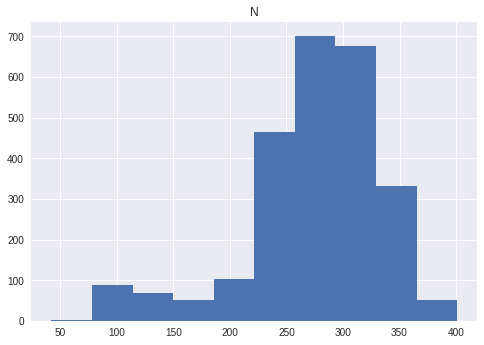

In [0]:
df10.hist()

### **So we can see most samples have around 300 variants in this gene.**




### **How many variants within DYRK1A gene for a particular sample that are shared by no other samples. These variants are called private variants.**

One way to do this would be to filter out variant positions that have a single sample ID associated with it.

In [0]:
df10z = pd.io.gbq.read_gbq('''

WITH
t1 AS (
SELECT
    reference_name,
    start_position,
    call.name,
    call.genotype[OFFSET(0)] g1,
    call.genotype[OFFSET(1)] g2
  FROM
    `isb-cgc.QotM.1000genomes`
  JOIN
  UNNEST(call) AS call WITH OFFSET AS ci
  WHERE
    reference_name = '21'
    AND (start_position BETWEEN 37365790 AND 37517450)
),

t2 AS (
SELECT
  start_position,
  COUNT(start_position) as N
FROM
  t1
WHERE
  (g1 = 1 OR g2 = 1)
GROUP BY
  start_position 
)

select COUNT(*) private_vars from t2 WHERE N = 1

''', project_id=project_id, verbose=False, dialect='standard')

df10z.head()


,private_vars
0,1852


### **OK! The above result shows 1852 private variants out of 11,369,475 variants in our table.**

### **Finally, let's do some statistics!  Let's do Z-scores. Now we could just work with the pandas table we already have, but for the example, let's do it in BigQuery.**

In [0]:
df11 = pd.io.gbq.read_gbq('''
WITH
t1 AS (
SELECT
    reference_name,
    start_position,
    call.name as sample,
    call.genotype[OFFSET(0)] g1,
    call.genotype[OFFSET(1)] g2
  FROM
    `isb-cgc.QotM.1000genomes`
  JOIN
  UNNEST(call) AS call WITH OFFSET AS ci
  WHERE
    reference_name = '21'
    AND (start_position BETWEEN 37365790 AND 37517450)
),

t2 AS (
  SELECT
    sample,
    COUNT(sample) as N
  FROM
    t1
  WHERE
    g1 = 1 OR g2 = 1
  GROUP BY
    sample
  ),

t3 AS (
SELECT
  AVG(N) avgn, 
  STDDEV(N) stddevn
FROM
  t2
), 

t4 AS (
  SELECT
    sample,
    N,
    avgn,
    stddevn,
    (N - avgn) / stddevn as Z_score
  FROM
    t2 CROSS JOIN t3
)

select * from t4
''', project_id=project_id, verbose=False, dialect='standard')

df11.head()

,sample,N,avgn,stddevn,Z_score
0,HG01086,256,275.190533,58.873981,-0.325959
1,HG03342,256,275.190533,58.873981,-0.325959
2,HG03694,256,275.190533,58.873981,-0.325959
3,HG00110,256,275.190533,58.873981,-0.325959
4,HG00116,256,275.190533,58.873981,-0.325959


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0585da1a20>,
      dtype=object)

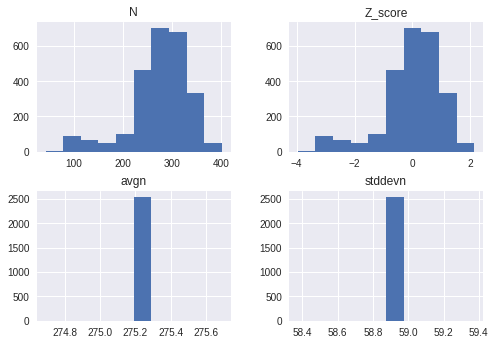

In [0]:
df11.hist()

IS THIS RIGHT??

### **So, the above query calculated Z-scores for a single gene. Let's make another query where we construct a series of bins, one bin per million bases, and compute a Z-score per sample, per bin.**

This is adapted from the Google tutorial (https://codelabs.developers.google.com/codelabs/genomics-vcfbq/index.html?index=..%2F..index#0
).

In [0]:

df13 = pd.io.gbq.read_gbq('''

#standardsql
WITH ind AS (
  -- count variants for each sample/ref/bin
  SELECT
    call.name AS sample, 
    reference_name AS ref, 
    FLOOR(start_position/1000000) AS bin, 
    COUNT(call.name) AS n
  FROM `isb-cgc.QotM.1000genomes` 
  JOIN UNNEST(call) AS call
  JOIN UNNEST(alternate_bases) AS alt
  WHERE alt.alt != '<*>'
    AND (call.genotype[OFFSET(0)] = 1 OR call.genotype[OFFSET(1)] = 1)
  GROUP BY sample, ref, bin
),

pop AS (
  -- overall all samples in ref/bin
  SELECT 
    ref, 
    bin, 
    AVG(n) AS pop_mu, 
    STDDEV(n) AS pop_sigma
  FROM ind
  GROUP BY ref, bin
),

zscore AS (
  SELECT 
    ind.sample, 
    ind.n AS ind_n,
    (ind.n-pop.pop_mu)/pop.pop_sigma AS z, 
    pop.ref, 
    pop.bin, 
    pop.pop_mu, 
    pop.pop_sigma
  FROM pop, ind
  WHERE ind.ref = pop.ref AND ind.bin = pop.bin
)

SELECT * from zscore
ORDER BY ABS(Z) DESC

''', project_id=project_id, verbose=False, dialect='standard')        
   
df13.head()




,sample,ind_n,z,ref,bin,pop_mu,pop_sigma
0,HG02623,665,5.591835,21,10.0,515.824458,26.677389
1,HG02574,663,5.516865,21,10.0,515.824458,26.677389
2,HG02645,647,4.917106,21,10.0,515.824458,26.677389
3,HG01384,840,-4.729486,21,39.0,1712.270611,184.432426
4,HG03867,992,-4.715188,21,15.0,1923.495069,197.552059


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff06e966390>,
      dtype=object)

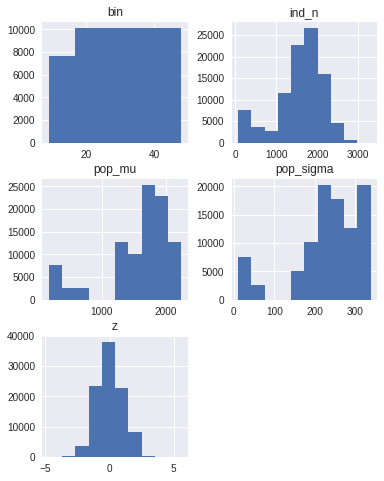

In [0]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [6, 8]

df13.hist()

### **But what about the case when you have mulple alleles?**





To work with that, we need to select the right alternate allele using the genotype calls.



In [0]:
df14 = pd.io.gbq.read_gbq('''

SELECT
reference_name as chr,
start_position,
reference_bases ,
--
--  if the genotype is 0, it's a ref call
--  else use the genotype call to index the alternative base
--
IF( (call.genotype[OFFSET(0)] = 0), 
     reference_bases, 
     alternate_bases[OFFSET(call.genotype[OFFSET(0)] - 1)].alt ) as alt1,
--
--
IF( (call.genotype[OFFSET(1)] = 0), 
     reference_bases, 
     alternate_bases[OFFSET(call.genotype[OFFSET(1)] - 1)].alt ) AS alt2,
--
--  then we're still unnesting a single column.
--
call.name,
call.genotype[OFFSET(0)] AS g1,
call.genotype[OFFSET(1)] AS g2
FROM
  `isb-cgc.QotM.1000genomes`
JOIN
  UNNEST(call) as call
WHERE
  reference_name = '21'
  AND call.name = 'HG00119'
  AND start_position = 34434667

''', project_id=project_id, verbose=False, dialect='standard'
)

df14.head()



,reference_name,start_position,reference_bases,alt1,alt2,name,g1,g2
0,21,34434667,G,T,G,HG00119,2,0
